# Convolutional Neural Networks for Hyperspectral Image Classification

Goals of the lecture:
1. Strengthen understanding of pixel-based classification for hyperspectral images
2. Simple 1D/2D-CNN architectures in PyTorch
3. Understand Dataset and DataLoader in PyTorch
4. Set-Up a training procedure with PyTorch
5. Train and evaluate neural networks

The Original Hyperspectral dataset is publicly available at [http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes). This notebook downloads the Pavia dataset automatically for you to "./data". Alternatively, you can download it as a zip file directly from the TUB-cloud: https://tubcloud.tu-berlin.de/s/j9KR2gR35wCGP87/download/PaviaU.zip)

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import requests
from tqdm.notebook import tqdm
from pathlib import Path


def download_file_with_progress(url: str, output_file: Path):
    """
    Given a `url` as a String and an `output_file` as a file-path the item will
    be downloaded and written to the `output_file`. If the `output_file` already
    exists, it will be overwritten.
    """
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))
    chunk_size = 2**20  # mb

    with open(output_file, "wb") as f:
        for data in tqdm(
            response.iter_content(chunk_size=chunk_size),
            total=total_size // chunk_size,
            unit="MB",
            unit_scale=True,
            desc="Downloading",
        ):
            f.write(data)

In [3]:
data_path = Path("./data")
data_path.mkdir(exist_ok=True)
# For quick prototyping there is on such things as _too many_ asserts!
assert data_path.exists, "Should exist after calling mkdir!"

## Download Dataset from Original Repo 

This notebook downloads "PaviaU" hyperspectral image and its corresponding ground reference map (class labels assigned per pixel). 

* "PaviaU" image includes 103 bands.

* Land cover map includes 9 classes 'Asphalt', 'Meadows', 'Gravel', 'Trees', \
'Painted metal sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows'.

**Note:** that in the classification map some areas are not labeled ('Undefined') that have to be excluded.

In [4]:
import zipfile
import scipy.io

In [5]:
class PaviaU():
    def __init__(self, base_dir: str):
        
        self.download_dataset(base_dir)
        self.datacube = self.normalize_img(self.open_datacube(base_dir))
        self.gt = self.open_gt(base_dir)

        self.class_names = np.array([
            "Undefined",
            "Asphalt",
            "Meadows",
            "Gravel",
            "Trees",
            "Painted metal sheets",
            "Bare Soil", 
            "Bitumen",
            "Self-Blocking Bricks",
            "Shadows"
        ])
        self.ignored_labels = [0]
        self.rgb_bands = (29, 19, 9)
        self.num_bands = self.datacube.shape[-1]
        self.num_classes = len(self.class_names) - len(self.ignored_labels)
    
    def download_dataset(self, base_dir: str):
        paviaU_path = base_dir / "PaviaU.zip"
        download_file_with_progress(
            "https://tubcloud.tu-berlin.de/s/j9KR2gR35wCGP87/download/PaviaU.zip",
            paviaU_path,
        )
        zipf = zipfile.ZipFile(paviaU_path)
        zipf.extractall(base_dir)
    
    def open_datacube(self, base_dir: str) -> np.array:
        image_path = base_dir /  "PaviaU/PaviaU.mat"
        return scipy.io.loadmat(image_path)["paviaU"]
    
    def open_gt(self, base_dir: str) -> np.array:
        gt_path = base_dir / "PaviaU/PaviaU_gt.mat"
        return scipy.io.loadmat(gt_path)["paviaU_gt"]
    
    def normalize_img(self, img: np.array) -> np.array:
        img = np.asarray(img, dtype="float32")
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        return img

In [6]:
pavia_u = PaviaU(data_path)

Downloading:   0%|          | 0.00/33.0 [00:00<?, ?MB/s]

In [7]:
pavia_u.datacube.shape # pixels and bands

(610, 340, 103)

In [8]:
pavia_u.num_classes # wo undefined

9

## Visualization of the Image and Land Cover Map (Classification Map)

In [9]:
import matplotlib
import spectral

In [10]:
# create handles for legend
cmap = matplotlib.colormaps.get_cmap("tab10")
handles = [matplotlib.patches.Patch(color=cmap(i), label=pavia_u.class_names[i]) for i in range(10)]

In [11]:
def adjust_cmap(segmentation_map:np.array, cmap_name: str) -> matplotlib.colors.ListedColormap:
    "Adjust color pallette according to classes present in segmentation map."
    cmap = matplotlib.colormaps.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, cmap.N))
    adj_colors = colors[:np.max(segmentation_map) + 1]
    return matplotlib.colors.ListedColormap(adj_colors)

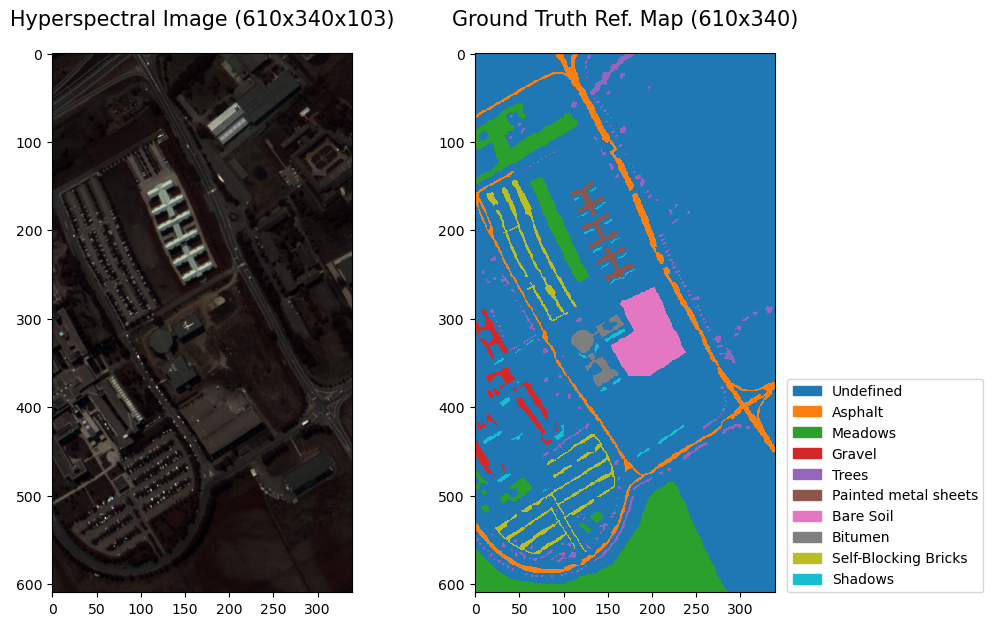

In [12]:
datacube_rgb = spectral.get_rgb(pavia_u.datacube, bands=pavia_u.rgb_bands)

fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title(
    "Hyperspectral Image ({}x{}x{})".format(*pavia_u.datacube.shape), fontsize=15, pad=20
)
axes[0].imshow(datacube_rgb)
axes[1].set_title("Ground Truth Ref. Map ({}x{})".format(*pavia_u.gt.shape), fontsize=15, pad=20)
axes[1].imshow(pavia_u.gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))
plt.show()

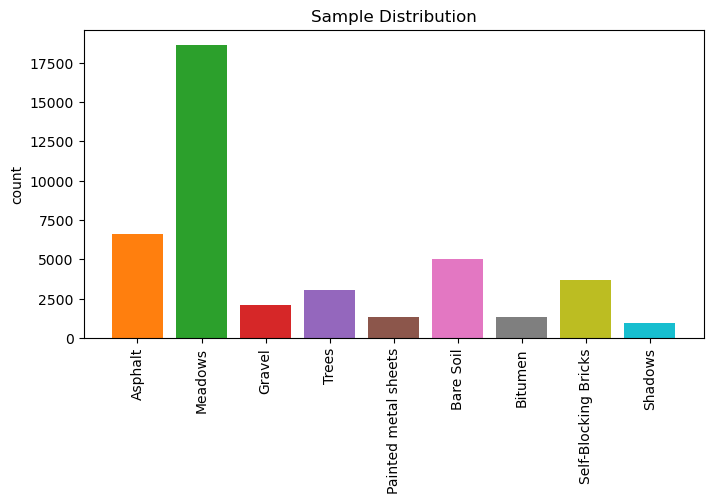

In [13]:
classes, counts = np.unique(pavia_u.gt, return_counts=True)

plt.figure(figsize=(8, 4))
plt.bar(
    classes[1:], counts[1:], tick_label=pavia_u.class_names[1:],
    color=adjust_cmap(pavia_u.gt, "tab10")(np.arange(1, 10))
)
plt.title('Sample Distribution')
plt.xticks(rotation=90)
plt.ylabel("count")
plt.show()

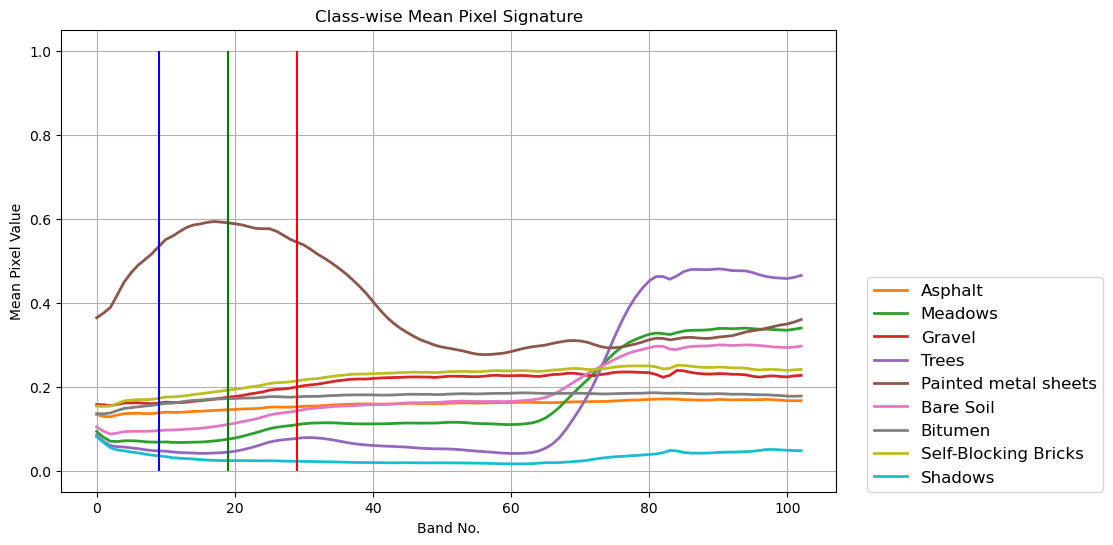

In [14]:
# sig across bands <- pixels mean
# difficult case
plt.figure(figsize=(10, 6))

for cl in range(1, 10):
    indices = np.nonzero(pavia_u.gt == cl)
    spectral_sig = pavia_u.datacube[indices].mean(axis=0)
    plt.plot(spectral_sig, label=pavia_u.class_names[cl], linewidth=2,
             color=adjust_cmap(pavia_u.gt, "tab10")(cl))

plt.title('Class-wise Mean Pixel Signature')
plt.legend(fontsize=12, loc=(1.04, 0))
plt.vlines(29, 0, 1, colors="r")
plt.vlines(19, 0, 1, colors="g")
plt.vlines(9, 0, 1, colors="b")
plt.xlabel("Band No.")
plt.ylabel("Mean Pixel Value")
plt.grid()
# for 1dcon

## Creating Train, Validation and Test sets

When training a neural network we need to create three sets namley one for train, on for validation and one for test purposes. After each training epoch we validate our model with the validation set. If the validation accuracy does not increase anymore, we store our best model, which we then evaluate on our test set.

In this pixel-based classification course each set (test/val/train) includes a certain number of samples (pixels). When using 2D or 3D convolutions each sample represents a pixel with its surroundings area (patch), and corresponding assigned class label. When using 1D convolutions each sample is just represented by its 103-band pixel.

For example for "CNN1D" each sample has 1x1x103 dimension (1x1 patch size and 103 spectral bands) and one label (between 0-9). For "CNN2D" each sample has 7x7x103 dimension (i.e., 7x7 patch size and 103 spectral bands).

In [15]:
def sample_gt(gt: np.array, train_percentage: float) -> (np.array, np.array):
    """
    Extract a fixed percentage of samples from an 2d-array of labels.

    Parameter
    ---------
    gt                : a 2D array of int labels
    train_percentage  : [0, 1] float

    Return
    ------
    train_gt, test_gt : 2D arrays of int labels

    """
    train_gt, test_gt = gt.copy(), gt.copy()

    for c in np.unique(gt):
        mask = gt == c
        for x in range(gt.shape[0]):
            first_half_count = np.count_nonzero(mask[:x, :])
            if first_half_count / np.count_nonzero(mask) > train_percentage:
                break

        train_mask = mask.copy()
        train_mask[:x, :] = 0
        train_gt[train_mask] = 0

        test_mask = mask.copy()
        test_mask[x:, :] = 0
        test_gt[test_mask] = 0

    return train_gt, test_gt

In [16]:
# subdivision func, call twice for val
train_and_val_gt, test_gt = sample_gt(pavia_u.gt, 0.5)

n_train_and_val = np.count_nonzero(train_and_val_gt)
n_test = np.count_nonzero(test_gt)
n_total = np.count_nonzero(pavia_u.gt)

print("Train&Val:  {} samples selected (over {})".format(n_train_and_val, n_total))
print("Test:       {} samples selected (over {})".format(n_test, n_total))

Train&Val:  21478 samples selected (over 42776)
Test:       21298 samples selected (over 42776)


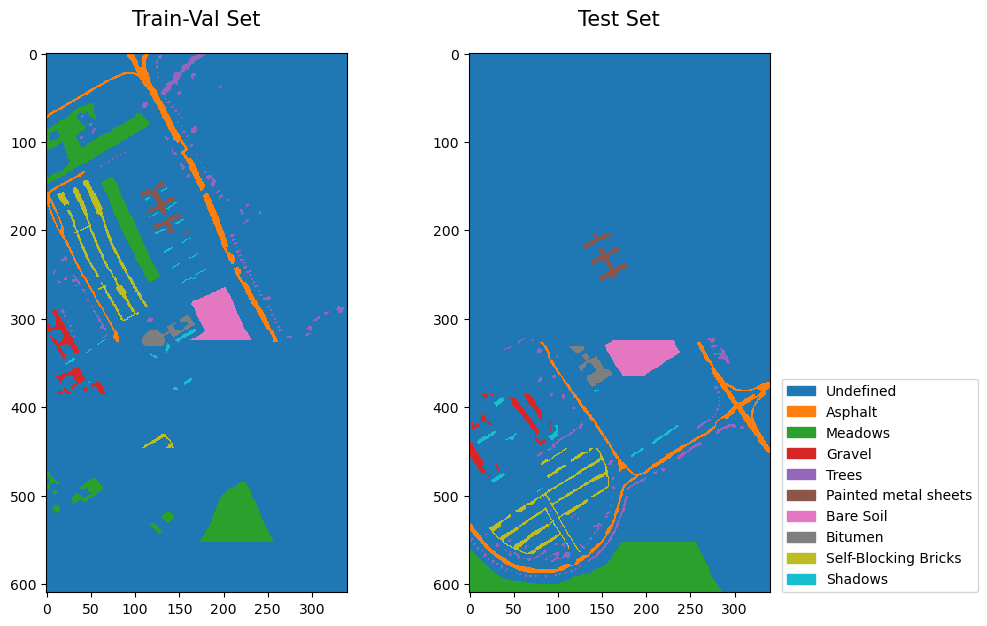

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("Train-Val Set", fontsize=15, pad=20)
axes[0].imshow(train_and_val_gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].set_title("Test Set", fontsize=15, pad=20)
axes[1].imshow(test_gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

In [18]:
# 2nd split: train - val split
train_gt, val_gt = sample_gt(train_and_val_gt, 0.8)

n_train = np.count_nonzero(train_gt)
n_val = np.count_nonzero(val_gt)

print("Train: {} samples selected (over {})".format(n_train, n_train_and_val))
print("Val:   {} samples selected (over {})".format(n_val, n_train_and_val))

Train: 17297 samples selected (over 21478)
Val:   4181 samples selected (over 21478)


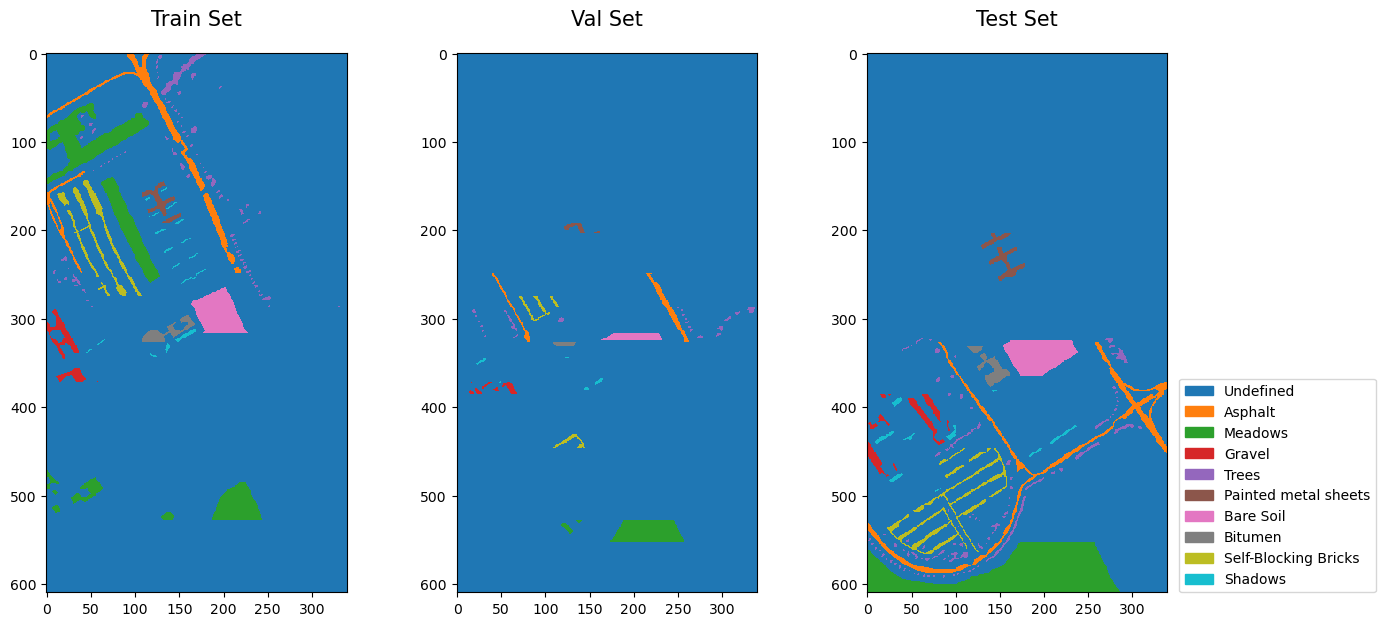

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes[0].set_title("Train Set", fontsize=15, pad=20)
axes[0].imshow(train_gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].set_title("Val Set", fontsize=15, pad=20)
axes[1].imshow(val_gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[2].set_title("Test Set", fontsize=15, pad=20)
axes[2].imshow(test_gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[2].legend(handles=handles, loc=(1.04, 0))

# Define CNN Architectures

With PyTorch you can build and add your own neural network architecture. In general, bulding a Neural network in PyTorch includes 3 main steps:
* Extend the nn.Module base class (e.g., class name_you_want(nn.Module))
* Define layers as class attributes
* Implement the forward() method

for more info check Pytorch documentation:

[https://pytorch.org/docs/master/nn.html#](https://pytorch.org/docs/master/nn.html#)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
# NN, integration, build archi
# nece: define, forward pass
# ?nn.Module

In [22]:
# ?nn.Conv1d # intiation and propogate forward
# ?nn.Conv2d # for images
# nn.Conv3d # block convolution

In [23]:
# ?nn.MaxPool1d

In [24]:
# border pixels: 0 padding, reflection padding? -> only pooling
# degration of conLayer by filter, pooling can be set (maxPooling)
# ?use padding for each layer -> set as para
# ?feature size <-> num of filters
class CNN1D(nn.Module):
    def __init__(self, width, num_classes, num_filter=10):
        super(CNN1D, self).__init__()
        self.width = width

        # 10 filter with kernel of size 12 x 1
        self.conv1 = nn.Conv1d(1, num_filter, kernel_size=(12,))
        self.pool1 = nn.MaxPool1d((3,))
        self.conv2 = nn.Conv1d(num_filter, num_filter, kernel_size=(12,))
        self.features_size = self._get_final_flattened_size()

        self.fc = nn.Linear(self.features_size, num_classes) # degrade features -> one class
        #self.apply(self.weight_init)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = x.reshape(-1, self.features_size)
        x = self.fc(x)
        return x

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, self.width)
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
        return x.numel()  # multiply shape

In [25]:
cnn1d = CNN1D(pavia_u.num_bands, pavia_u.num_classes)

In [26]:
from torchinfo import summary



In [27]:
# summary(cnn1d, input_size=(1, 103), col_names=["input_size", "output_size", "num_params"])

### Example how for different data the input/outputs of layers change

In [28]:
# ?summary

In [29]:
# summary(CNN1D(50, 100), input_size=(1, 50), col_names=["input_size", "output_size", "num_params"])

# Define Training Hyperparameter

In [30]:
def get_device(cuda_no):
    return torch.device('cpu') if cuda_no < 0 else torch.device(cuda_no)

In [31]:
# fmt: off
device         = get_device(-1)
patch_size     = 1  # 1 for 1D-CNN, 7 for 2D-CNN
batch_size     = 100
learning_rate  = 0.01
epochs         = 20
# fmt: on

In [32]:
import torch.optim as optim

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    cnn1d.parameters(), # for training loop across epochs
    lr=learning_rate,
    momentum=0.9, # smooth optimizer
    weight_decay=0.0005, # norm
    nesterov=True,
)

# Set-Up Dataset and DataLoader

In [33]:
from torch.utils.data import Dataset # samples related
from torch.utils.data import DataLoader # threading
from typing import List

In [34]:
# ?DataLoader

In [35]:
# ?Dataset

In [36]:
# preprocess
class PaviaUDataset(Dataset):
    
    def __init__(self, datacube: np.array, gt: np.array, ignored_labels: List[int] = [], patch_size: int = 1):
        
        self.datacube = datacube
        self.gt = gt
        self.coordinates = []
        self.patch_size = patch_size

        self.ignored_labels = ignored_labels
        self.active_classes = list(set(np.unique(self.gt)) - set(self.ignored_labels))
        self.num_active_classes = len(self.active_classes)
        self.active2squeezed = dict(zip(self.active_classes, range(self.num_active_classes)))
        self.squeezed2active = {v: k for k, v in self.active2squeezed.items()}
        
        self.readout_active_coordinates()
        
    def readout_active_coordinates(self):
        h, w, _ = self.datacube.shape
        
        active_classes_mask = np.zeros((h, w)) # active clases
        for cl in self.active_classes:
            active_classes_mask[self.gt == cl] = 1
        
        x_pos, y_pos = np.nonzero(active_classes_mask)
        p = self.patch_size // 2
        self.coordinates = [
            (x, y)
            for x, y in zip(x_pos, y_pos)
            if x > p and x < h - p and y > p and y < w - p
        ]   
        
    def __getitem__(self, idx: int): # ***
        x_cord, y_cord = self.coordinates[idx]
        target = self.gt[x_cord, y_cord]
        target = self.active2squeezed[target]

        if self.patch_size == 1:
            sample = self.datacube[x_cord, y_cord]
            # add channel dim that is always = 1
            sample = sample[np.newaxis, :]
        else:
            x1, y1 = x_cord - self.patch_size // 2, y_cord - self.patch_size // 2
            x2, y2 = x1 + self.patch_size, y1 + self.patch_size
            sample = self.datacube[x1:x2, y1:y2]
            
            # move channels to first axis (required by PyTorch)
            sample = np.moveaxis(sample, -1, 0)
            
        return sample, target, x_cord, y_cord
    
    def __len__(self):
        return len(self.coordinates) # ***

In [37]:
train_dataset = PaviaUDataset(pavia_u.datacube, train_gt, pavia_u.ignored_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = PaviaUDataset(pavia_u.datacube, val_gt, pavia_u.ignored_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = PaviaUDataset(pavia_u.datacube, test_gt, pavia_u.ignored_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [38]:
from tqdm.notebook import tqdm

def train(
    model: nn.Module,
    optimizer: torch.optim,
    criterion: torch.nn.modules.loss,
    train_loader: DataLoader,
    epochs: int,
    device: torch.device,
    val_loader: DataLoader = None,
):
    """
    Training loop to optimize a network for several epochs and a specified loss.

    Args:
    -----
    model               : a PyTorch model
    optimizer           : a PyTorch optimizer
    criterion           : a PyTorch-compatible loss function, e.g. nn.CrossEntropyLoss
    train_loader        : a PyTorch trainset loader
    epochs              : int specifying the number of training epochs
    device              : torch device to use (defaults to CPU)
    val_loader (opt.)   : validation dataset
    """
    model.to(device)  # put model on device
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in tqdm(range(1, epochs + 1), desc="Training the network"):
        model.train()  # set model to training mode
        train_losses_epoch = []
        train_targets = []
        train_preds = []

        # Data-Loading Loop
        with tqdm(train_loader, unit=" batch") as tepoch:
            for idx, (data, targets, _, _) in enumerate(tepoch):
                tepoch.set_description("Epoch {}".format(epoch))

                # put loaded data and targets on device
                data, targets = data.to(device), targets.to(device)

                # zero accumulated gradients from previous batch
                optimizer.zero_grad()

                # infer predictions for batch
                output = model(data)
                predictions = output.argmax(dim=1)

                # compute loss from predictions, CELoss automatically applies F.log_softmax
                loss = criterion(output, targets)

                # accumulate gradients for all parameter according to batch errors
                loss.backward()

                # update paramters according to accumulated gradients
                optimizer.step()
                
                train_losses_epoch.append(loss.item()) # load para here
                train_targets.append(targets)
                train_preds.append(predictions)
            
            curr_train_loss = np.mean(train_losses_epoch)
            train_targets = torch.cat(train_targets)
            train_preds = torch.cat(train_preds)
            
            correct = (train_preds == train_targets).sum().item()  # get value from tensor
            train_accuracy = correct / len(train_loader.dataset)
            train_losses.append(curr_train_loss)
            train_accuracies.append(train_accuracy)
            
            print("Train-Loss: {:.2f}. Train-Acc: {:.2f}".format(curr_train_loss, train_accuracy))

        if val_loader is not None:
            model.eval()
            val_losses_epoch = []
            val_targets = []
            val_preds = []

            with torch.no_grad():
                for data, targets, _, _ in val_loader:
                    # put loaded data and targets on device
                    data = data.to(device)
                    targets = targets.to(device)

                    output = model(data)
                    loss = criterion(output, targets)
                    predictions = output.argmax(dim=1)
                    
                    val_losses_epoch.append(loss.item())
                    val_targets.append(targets)
                    val_preds.append(predictions)
                    
            curr_val_loss = np.mean(val_losses_epoch)
            val_targets = torch.cat(val_targets)
            val_preds = torch.cat(val_preds)

            correct = (val_preds == val_targets).sum().item()
            val_accuracy = correct / len(val_loader.dataset)
            val_losses.append(curr_val_loss)
            val_accuracies.append(val_accuracy)

            print("Val-Loss:   {:.2f}. Val-Acc:   {:.2f}".format(curr_val_loss, val_accuracy))

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def test(
    model: nn.Module,
    test_loader: DataLoader,
    class_names: List[str],
    device: torch.device,
):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for idx, (data, target, _, _) in enumerate(tqdm(test_loader, desc="Test: ")):
            # put loaded data and targets on device
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            predicted = output.argmax(dim=1)

            predictions += predicted.tolist()
            targets += target.tolist()

    results = {}

    if class_names is None:
        class_names = range(len(np.unique(targets)))

    cm = confusion_matrix(targets, predictions)

    results["cm"] = cm
    results["overall_acc"] = accuracy_score(targets, predictions)
    results["report"] = classification_report(
        targets,
        predictions,
        target_names=class_names,
        zero_division=0,
        digits=2,
    )

    return results

In [40]:
train(
    model=cnn1d,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 1.46. Train-Acc: 0.52
Val-Loss:   0.81. Val-Acc:   0.66


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.74. Train-Acc: 0.73
Val-Loss:   0.59. Val-Acc:   0.77


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.67. Train-Acc: 0.75
Val-Loss:   0.96. Val-Acc:   0.41


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.57. Train-Acc: 0.80
Val-Loss:   0.78. Val-Acc:   0.75


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.52. Train-Acc: 0.82
Val-Loss:   0.67. Val-Acc:   0.72


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.48. Train-Acc: 0.84
Val-Loss:   1.44. Val-Acc:   0.34


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.45. Train-Acc: 0.84
Val-Loss:   2.57. Val-Acc:   0.43


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.45. Train-Acc: 0.85
Val-Loss:   0.58. Val-Acc:   0.77


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.41. Train-Acc: 0.86
Val-Loss:   0.66. Val-Acc:   0.65


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.40. Train-Acc: 0.86
Val-Loss:   0.75. Val-Acc:   0.61


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.39. Train-Acc: 0.86
Val-Loss:   0.59. Val-Acc:   0.72


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.38. Train-Acc: 0.87
Val-Loss:   1.38. Val-Acc:   0.51


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.39. Train-Acc: 0.87
Val-Loss:   0.92. Val-Acc:   0.55


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.37. Train-Acc: 0.87
Val-Loss:   0.44. Val-Acc:   0.81


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.37. Train-Acc: 0.87
Val-Loss:   0.49. Val-Acc:   0.80


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.36. Train-Acc: 0.88
Val-Loss:   0.50. Val-Acc:   0.81


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.35. Train-Acc: 0.88
Val-Loss:   0.36. Val-Acc:   0.86


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.35. Train-Acc: 0.88
Val-Loss:   0.40. Val-Acc:   0.83


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.35. Train-Acc: 0.88
Val-Loss:   0.61. Val-Acc:   0.67


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.34. Train-Acc: 0.88
Val-Loss:   1.21. Val-Acc:   0.50


## Evaluate - Visualization of Predicted Map

In [41]:
full_dataset = PaviaUDataset(pavia_u.datacube, pavia_u.gt, pavia_u.ignored_labels)
full_loader = DataLoader(full_dataset, batch_size=100)

In [42]:
# insted of test -> inference over dataset
def infer_image(
    model: nn.Module,
    full_loader: DataLoader,
    class_names: List[str],
    device: torch.device,
    gt: np.array,
):  
    model.eval()
    output = np.zeros(gt.shape)
    
    predictions = []
    targets_list = []
    x_cords_list = []
    y_cords_list = []
    
    with torch.no_grad():
        for idx, (batch, targets, x_cord, y_cord) in enumerate(tqdm(full_loader, desc="Inference on whole image: ")):
            # put loaded data on GPU
            batch = batch.to(device)

            logits = model(batch)
            probs = F.softmax(logits, dim=1)
            _, predicted = torch.max(probs.data, 1)
            predictions += predicted.tolist()
            targets_list += targets
            x_cords_list += x_cord
            y_cords_list += y_cord
    
    for i, pred in enumerate(predictions):
        output[x_cords_list[i], y_cords_list[i]] = full_loader.dataset.squeezed2active[pred] # ***
    
    return output

In [43]:
active_cl_names = pavia_u.class_names[test_dataset.active_classes]

In [44]:
prediction = infer_image(cnn1d, full_loader, active_cl_names, device, pavia_u.gt)

Inference on whole image:   0%|          | 0/427 [00:00<?, ?it/s]

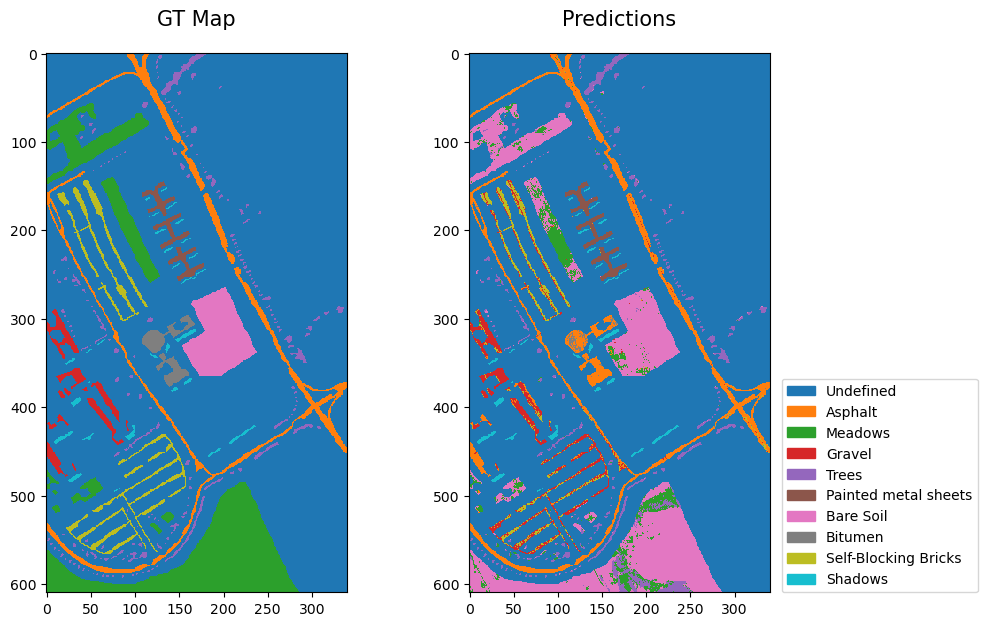

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("GT Map", fontsize=15, pad=20)
axes[0].imshow(pavia_u.gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].set_title("Predictions", fontsize=15, pad=20)
axes[1].imshow(prediction, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

## Evaluate - Metrics

In [46]:
import pandas as pd
import seaborn as sns

In [47]:
results = test(cnn1d, test_loader, active_cl_names, device)

Test:   0%|          | 0/213 [00:00<?, ?it/s]

In [48]:
print(results["report"])

                      precision    recall  f1-score   support

             Asphalt       0.73      0.92      0.82      3301
             Meadows       0.72      0.10      0.18      9246
              Gravel       0.31      0.52      0.38      1031
               Trees       0.59      0.92      0.72      1531
Painted metal sheets       1.00      1.00      1.00       666
           Bare Soil       0.23      0.88      0.36      2487
             Bitumen       0.64      0.07      0.13       660
Self-Blocking Bricks       0.71      0.34      0.46      1833
             Shadows       1.00      1.00      1.00       473

            accuracy                           0.47     21228
           macro avg       0.66      0.64      0.56     21228
        weighted avg       0.65      0.47      0.41     21228



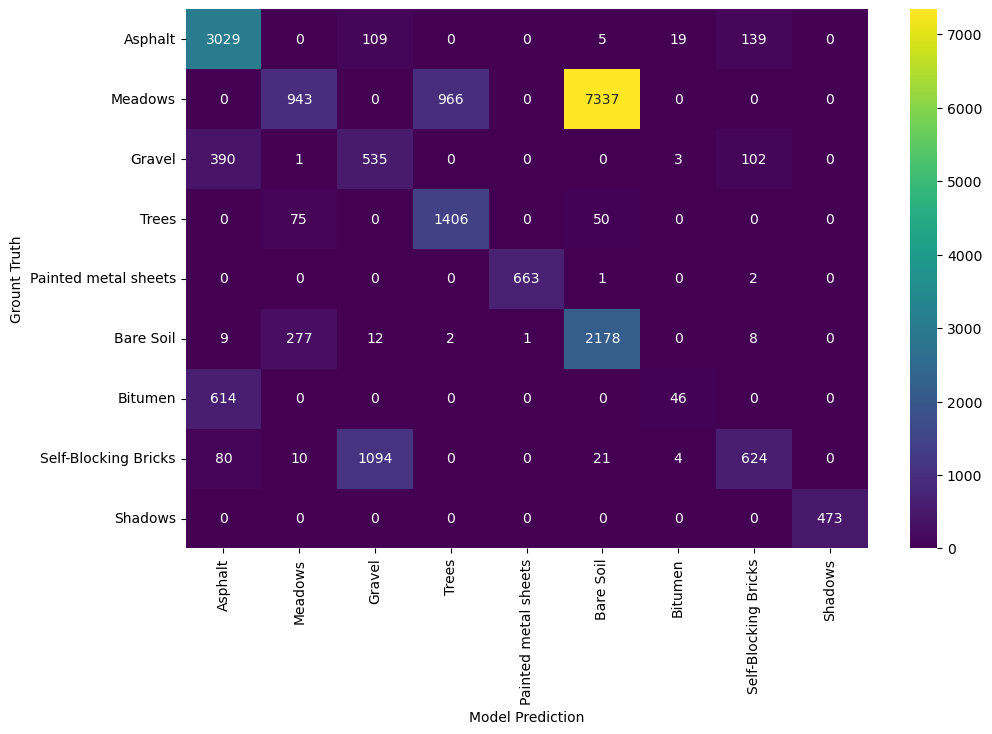

In [49]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=active_cl_names,
    yticklabels=active_cl_names,
    annot=True,
)
ax.set(xlabel="Model Prediction", ylabel="Grount Truth")
plt.show()

## In-course practice I

Use the model `CNN2D` for training and instantiate it with 18 filters. This model is a deep network with 2D convolution layer which requires 103x7x7 patches. 

What you need to do:

- Change the patch size
- Intantiate the new model and re-intantiate the optimizer and data loaders
- Train and evaluate the model

In [69]:
class CNN2D(nn.Module):
    def __init__(self, input_size, num_classes, num_filter=2):
        super(CNN2D, self).__init__()
        self.input_size = input_size

        self.conv1 = nn.Conv2d(input_size[0], num_filter, kernel_size=(3, 3), padding=1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(num_filter, 2 * num_filter, kernel_size=(3, 3), padding=0)
        self.features_size = self._get_final_flattened_size()

        self.fc = nn.Linear(self.features_size, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = x.reshape(-1, self.features_size)
        x = self.fc(x)
        return x

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros((1, *self.input_size))
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
        return x.numel()  # multiply shape

In [77]:
cnn2d = CNN1D(pavia_u.num_bands, pavia_u.num_classes)

In [71]:
# summary(cnn2d, input_size=(103, 7, 7), col_names=["input_size", "output_size", "num_params"])

In [78]:
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    cnn2d_custom.parameters(), # for training loop across epochs
    lr=learning_rate,
    momentum=0.9, # smooth optimizer
    weight_decay=0.0005, # norm
    nesterov=True,
)

In [82]:
train_dataset = PaviaUDataset(pavia_u.datacube, train_gt, pavia_u.ignored_labels, 7)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = PaviaUDataset(pavia_u.datacube, val_gt, pavia_u.ignored_labels, 7)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = PaviaUDataset(pavia_u.datacube, test_gt, pavia_u.ignored_labels, 7)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [80]:
# train_dataset = ...
# train_loader = ...

# val_dataset = ...
# val_loader = ...

# test_dataset = ...
# test_loader = ...

In [83]:
train(
    model=cnn2d,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ? batch/s]

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [100, 103, 7, 7]

In [ ]:
full_dataset = ...
full_loader = ...

In [ ]:
prediction = infer_image(cnn2d, full_loader, active_cl_names, device, pavia_u.gt)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("GT Map", fontsize=15, pad=20)
axes[0].imshow(pavia_u.gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].set_title("Predictions", fontsize=15, pad=20)
axes[1].imshow(prediction, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

In [ ]:
results = test(cnn2d, test_loader, active_cl_names, device)

In [ ]:
print(results["report"])

In [ ]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=active_cl_names,
    yticklabels=active_cl_names,
    annot=True,
)
ax.set(xlabel="Model Prediction", ylabel="Grount Truth")
plt.show()

## In-course practice II

Add one `Conv2D` layer and one `AvgPool2D` layer to the 2D-CNN and retrain the network. Therefore, alternate the padding of `conv2` to 1 and add the `conv3` with input and output filter size `2 * num_filter`, a kernel of (3, 3) and a padding of 1. The `AvgPool2D` should be of kernel size (3, 3). Activate the third `Conv2D` with a ReLU function (like for `conv1` and `conv2`).

More information on parameters for the convolutional layer and the respective impact on the output shape can be found in the documentation of PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [50]:
# patch -> 7*7?
class CNN2D_custom(nn.Module):
    def __init__(self, input_size, num_classes, num_filter=2):
        super(CNN2D_custom, self).__init__()
        self.input_size = input_size

        self.conv1 = nn.Conv2d(input_size[0], num_filter, kernel_size=(3, 3), padding=1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(num_filter, 2 * num_filter, kernel_size=(3, 3), padding=0)
        self.features_size = self._get_final_flattened_size()

        self.fc = nn.Linear(self.features_size, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = x.reshape(-1, self.features_size)
        x = self.fc(x)
        return x

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros((1, *self.input_size))
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
        return x.numel()  # multiply shape

In [51]:
cnn2d_custom = CNN1D(pavia_u.num_bands, pavia_u.num_classes)

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = ...

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    cnn2d_custom.parameters(), # for training loop across epochs
    lr=learning_rate,
    momentum=0.9, # smooth optimizer
    weight_decay=0.0005, # norm
    nesterov=True,
)

In [52]:
# summary(cnn2d_custom, input_size=(103, 7, 7), col_names=["input_size", "output_size", "num_params"])

In [68]:
train(
    model=cnn2d_custom,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.33. Train-Acc: 0.89
Val-Loss:   0.47. Val-Acc:   0.82


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.33. Train-Acc: 0.88
Val-Loss:   0.44. Val-Acc:   0.81


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.32. Train-Acc: 0.89
Val-Loss:   0.71. Val-Acc:   0.77


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.32. Train-Acc: 0.89
Val-Loss:   0.39. Val-Acc:   0.83


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.32. Train-Acc: 0.89
Val-Loss:   0.64. Val-Acc:   0.70


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.31. Train-Acc: 0.89
Val-Loss:   0.83. Val-Acc:   0.65


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.32. Train-Acc: 0.89
Val-Loss:   0.38. Val-Acc:   0.83


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.31. Train-Acc: 0.89
Val-Loss:   0.37. Val-Acc:   0.84


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.30. Train-Acc: 0.89
Val-Loss:   0.45. Val-Acc:   0.83


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.31. Train-Acc: 0.90
Val-Loss:   0.45. Val-Acc:   0.79


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.30. Train-Acc: 0.90
Val-Loss:   0.47. Val-Acc:   0.78


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.30. Train-Acc: 0.90
Val-Loss:   0.37. Val-Acc:   0.87


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.29. Train-Acc: 0.90
Val-Loss:   0.57. Val-Acc:   0.72


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.29. Train-Acc: 0.90
Val-Loss:   0.38. Val-Acc:   0.82


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.29. Train-Acc: 0.90
Val-Loss:   0.35. Val-Acc:   0.85


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.29. Train-Acc: 0.90
Val-Loss:   0.33. Val-Acc:   0.85


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.28. Train-Acc: 0.91
Val-Loss:   0.41. Val-Acc:   0.84


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.29. Train-Acc: 0.90
Val-Loss:   0.65. Val-Acc:   0.64


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.28. Train-Acc: 0.90
Val-Loss:   0.74. Val-Acc:   0.64


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.28. Train-Acc: 0.90
Val-Loss:   0.36. Val-Acc:   0.84


In [60]:
prediction = infer_image(cnn2d_custom, full_loader, active_cl_names, device, pavia_u.gt)

Inference on whole image:   0%|          | 0/427 [00:00<?, ?it/s]

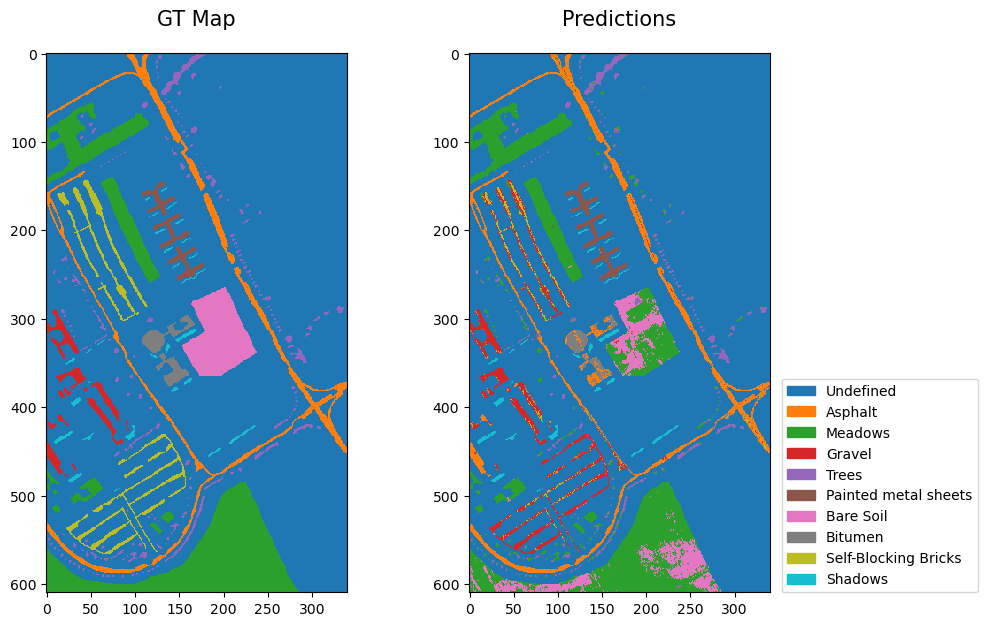

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("GT Map", fontsize=15, pad=20)
axes[0].imshow(pavia_u.gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].set_title("Predictions", fontsize=15, pad=20)
axes[1].imshow(prediction, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

In [62]:
results = test(cnn2d_custom, test_loader, active_cl_names, device)

Test:   0%|          | 0/213 [00:00<?, ?it/s]

In [63]:
print(results["report"])

                      precision    recall  f1-score   support

             Asphalt       0.82      0.84      0.83      3301
             Meadows       0.73      0.66      0.69      9246
              Gravel       0.26      0.56      0.35      1031
               Trees       0.97      0.64      0.77      1531
Painted metal sheets       1.00      0.99      1.00       666
           Bare Soil       0.20      0.33      0.25      2487
             Bitumen       0.53      0.60      0.56       660
Self-Blocking Bricks       0.53      0.13      0.21      1833
             Shadows       1.00      1.00      1.00       473

            accuracy                           0.61     21228
           macro avg       0.67      0.64      0.63     21228
        weighted avg       0.67      0.61      0.62     21228



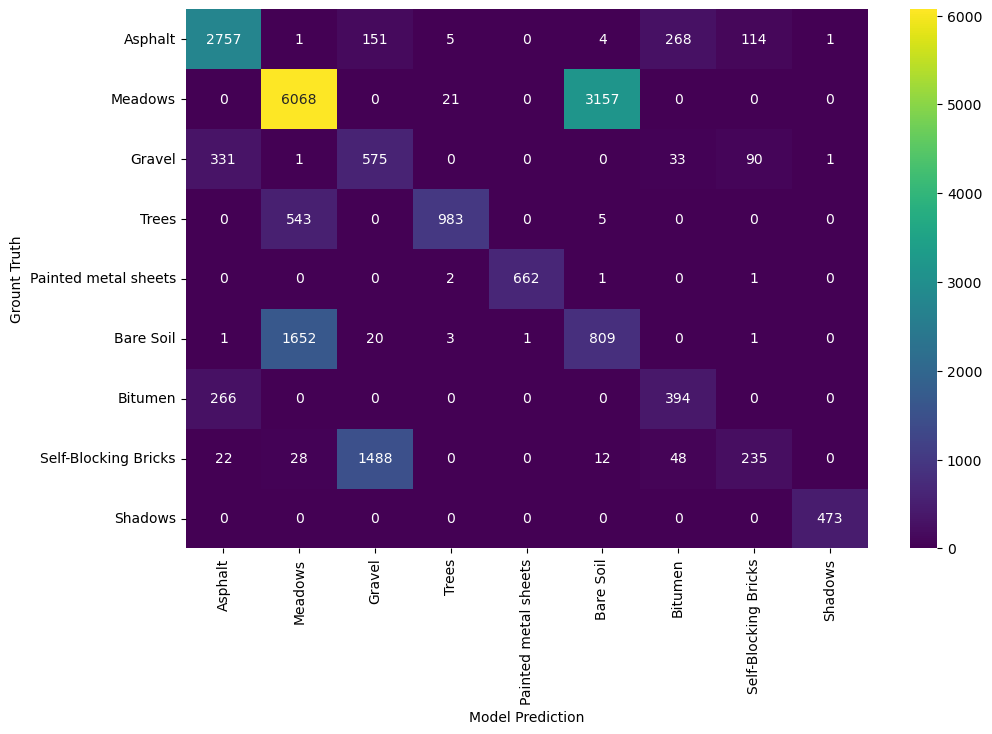

In [64]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=active_cl_names,
    yticklabels=active_cl_names,
    annot=True,
)
ax.set(xlabel="Model Prediction", ylabel="Grount Truth")
plt.show()